In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import math
from prettyplotlib import *
from random import sample
import csv

In [ ]:
%run data_generating_functions.py
%run data_fitting_functions.py

In [3]:
# Define colors to use here
logistic_color = "#C89AD5"
dark_logistic_color = "#AD5C8D"
scaled_logit_color = "#66B7AF"
dark_scaled_logit_color = "#2E605B"
inf_color = "#FF5C5F"#FE4820"

In [4]:
def get_params_for_link_function(link_function):
    if link_function == "threshold":
        return {"thresh": 6, "max_val": 1}  # Log-scale threshold
    elif link_function == "exponential":
        return {"x_intercept": 1, "steepness": -.6}  # Log-scale exponential
    elif link_function == "sigmoid":
        return {"steepness": 2, "mid_point": 6}  # Log-scale sigmoid
    elif link_function == "no_relationship":
        return {}
    else:
        raise ValueError(f"Invalid relationship type: {link_function}")


In [5]:
def generate_paired_random_sample(sz,list1,list2):
    ''' Generate a paired random sample (with replacement) of size 'sz' from two lists 
    Returns two lists containing matched samples from list1 and list2
    '''
    list1_samples = []; list2_samples = [];
    list_size = len(list1)
    for ii in range(sz):
        to_sample = np.random.randint(0,list_size)
        list1_samples.append(list1[to_sample])
        list2_samples.append(list2[to_sample])
    return np.array(list1_samples),np.array(list2_samples)


In [6]:
# Set constants
N = 100000      # Total number of individuals sampled in TND data
n_plot = 1000   # Number of samples to plot

# Figure 1
Logistic regression can only provide an unbiased estimate of exponential relationship

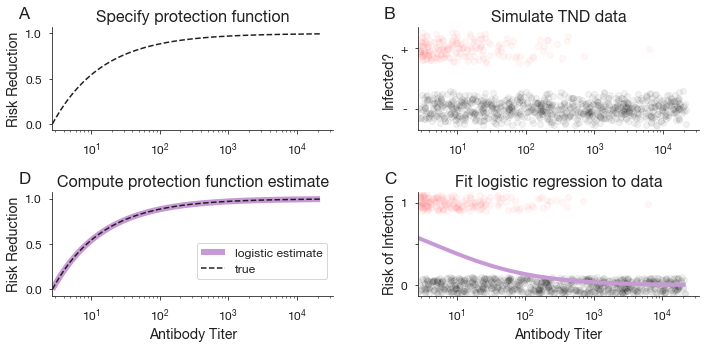

In [31]:
gen_func = "exponential"

figure_mosaic = """
AB
DC
"""
fig_labs = ["A","B","D","C"]

fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic,figsize=(10,5))

# Showing how standard logistic regression estimates risk
param_dict = get_params_for_link_function(gen_func)
TND = generate_TND_data(N,gen_func,protection_params=param_dict)
Ab_logged = TND[0]; infected = TND[1]
Ab_unlogged = np.exp(Ab_logged)
Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

# Use logistic regression to estimate risk 
potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
potential_Abs_unlogged = np.exp(potential_Abs_logged)
inf_probs = fit_logistic_regression(Ab_logged,infected,potential_Abs_logged)

# Use odds ratio from best-fit logistic regression to calculate risk reduction
RR_estimate = one_minus_OR(inf_probs)

# Calculate estimated and simulated VE
exec(f"X = {gen_func}") 
p1,p2 = list(param_dict.values())
RR_simulated = [X(Ab,p1,p2) for Ab in potential_Abs_logged]

# Panel A -------------------------------------------------------------
# Specify Risk reduction curve
ax = axes["A"]
simulated = ax.plot(potential_Abs_unlogged,RR_simulated,c=ALMOST_BLACK,linestyle="dashed",label="true")
# ax.set_xlabel("Antibody Titer")
ax.set_ylabel("Risk Reduction")
ax.set_title("Specify protection function",size=LABEL_SIZE+2)
hide_right_top_axis(ax)
# ax.set_xlim([0,3000]); 
ax.set_xscale('log')
ax.set_ylim([-0.07,1.07])

# Panel B -------------------------------------------------------------
# Simulate data
infected_samples_full = jitter_vector(infected_samples,jitter_range=0.2)

ax = axes["B"]
ax.scatter(Ab_unlogged_samples[infected_samples_full > 0.5], infected_samples_full[infected_samples_full > 0.5], c=inf_color, alpha=0.05, label="infected")
ax.scatter(Ab_unlogged_samples[infected_samples_full < 0.5], infected_samples_full[infected_samples_full < 0.5], c="k" ,alpha=0.05, label="not infected")
# ax.set_xlabel("Antibody Titer")
ax.set_ylabel("Infected?")
ax.set_title("Simulate TND data",size=LABEL_SIZE+2)
hide_right_top_axis(ax)
# ax.set_xlim([0,3000]); 
# ax.set_ylim([-0.4,1.4])
ax.set_xscale('log')
ax.set_yticks([0,1]); ax.set_yticklabels(["-","+"])

# Panel C -------------------------------------------------------------
# Show logistic model fit
ax = axes["C"]
ax.scatter(Ab_unlogged_samples[infected_samples > 0.5], infected_samples[infected_samples > 0.5], c=inf_color, alpha=0.05)
ax.scatter(Ab_unlogged_samples[infected_samples < 0.5], infected_samples[infected_samples < 0.5], c="k" ,alpha=0.05)
ax.plot(potential_Abs_unlogged,inf_probs,c=logistic_color,linewidth=4)
ax.set_xlabel("Antibody Titer")
ax.set_ylabel("Risk of Infection")
ax.set_title("Fit logistic regression to data",size=LABEL_SIZE+2)
hide_right_top_axis(ax)
# ax.set_xlim([0,3000]); 
ax.set_ylim([-0.125,1.125])
ax.set_xscale('log')
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,None,1])

# Panel D -------------------------------------------------------------
# Showing odds ratio definition of risk reduction for exponential
ax = axes["D"]

estimated = ax.plot(potential_Abs_unlogged,RR_estimate,c=logistic_color,label="logistic estimate",linewidth=6)
simulated = ax.plot(potential_Abs_unlogged,RR_simulated,c=ALMOST_BLACK,linestyle="dashed",label="true")
ax.set_xlabel("Antibody Titer")
hide_right_top_axis(ax)
# ax.set_xlim([0,3000])
ax.set_ylim([-0.07,1.07])
ax.set_ylabel("Risk Reduction")   
ax.set_title("Compute protection function estimate",size=LABEL_SIZE+2)
ax.set_xscale('log')

leg = ax.legend(bbox_to_anchor=(1,0.1),loc="lower right",fontsize=LABEL_SIZE-2)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ypad = 1.2; xpad = -0.12
label_subplots(axes, [xpad,xpad,xpad,xpad], y_pad=ypad, labels=fig_labs)

for ax_lab in fig_labs:
    axes[ax_lab].set_xlim([min(Ab_unlogged),None])
    finalize(axes[ax_lab])

# Show the plot 
plt.grid(False)
plt.tight_layout()
fig.subplots_adjust(hspace=0.6,wspace=0.3) # space between rows, columns
plt.savefig("figs/raw/Fig1_raw.jpg",dpi=300,bbox_inches='tight')
plt.show()

# Figure 2
Logistic regression does not provide accurate estimate of sigmoidal protection function

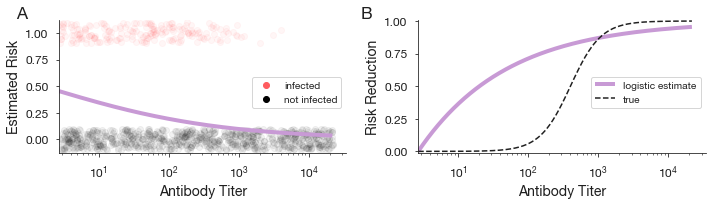

In [9]:
gen_func = "sigmoid"

figure_mosaic = """
AB
"""
fig_labs = ["A","B"]

fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic,figsize=(10,3))

# Panel A -------------------------------------------------------------
# Showing how standard logistic regression estimates risk
# Showing how standard logistic regression estimates risk
param_dict = get_params_for_link_function(gen_func)
TND = generate_TND_data(N,gen_func,protection_params=param_dict)
Ab_logged = TND[0]; infected = TND[1]
Ab_unlogged = np.exp(Ab_logged)
Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

# Use logistic regression to estimate risk 
potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
potential_Abs_unlogged = np.exp(potential_Abs_logged)
inf_probs = fit_logistic_regression(Ab_logged,infected,potential_Abs_logged)

# Use odds ratio from best-fit logistic regression to calculate risk reduction
RR_estimate = one_minus_OR(inf_probs)

# Calculate estimated and simulated VE
exec(f"X = {gen_func}") 
p1,p2 = list(param_dict.values())
RR_simulated = [X(Ab,p1,p2) for Ab in potential_Abs_logged]

# Plot a single simulation for each data generating function
ax = axes["A"]
ax.scatter(Ab_unlogged_samples[infected_samples > 0.5], infected_samples[infected_samples > 0.5], c=inf_color, alpha=0.05, label="infected")
ax.scatter(Ab_unlogged_samples[infected_samples < 0.5], infected_samples[infected_samples < 0.5], c="k" ,alpha=0.05, label="not infected")
ax.plot(potential_Abs_unlogged,inf_probs,c=logistic_color,linewidth=4)
ax.set_xlabel("Antibody Titer")
ax.set_ylabel("Estimated Risk")
hide_right_top_axis(ax)
ax.set_ylim([-0.125,1.125])

leg = ax.legend(bbox_to_anchor=(1,0.3),loc="lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# Panel B -------------------------------------------------------------
# Showing odds ratio definition of risk reduction for exponential
ax = axes["B"]

# Use odds ratio from best-fit logistic regression to calculate risk reduction
RR_estimate = one_minus_OR(inf_probs)

# Calculate estimated and simulated VE
exec(f"X = {gen_func}") 
p1,p2 = list(param_dict.values())
RR_simulated = [X(Ab,p1,p2) for Ab in potential_Abs_logged]

# Plot a single simulation for each data generating function
ax.plot(potential_Abs_unlogged,RR_estimate,c=logistic_color,linewidth=4,label="logistic estimate")
simulated = ax.plot(potential_Abs_unlogged,RR_simulated,c=ALMOST_BLACK,linestyle="dashed",label="true")
ax.set_xlabel("Antibody Titer")
hide_right_top_axis(ax)
ax.set_ylim([-0.01,1.01])
ax.set_ylabel("Risk Reduction")   
leg = ax.legend(bbox_to_anchor=(1,0.3),loc="lower right")

ypad = 1.1
label_subplots(axes, [-0.15,-0.2], y_pad=ypad, labels=fig_labs)
ax_labs = ["A","B"]
for ax_lab in ax_labs:
    axes[ax_lab].set_xscale('log')
    axes[ax_lab].set_xlim([min(Ab_unlogged),None])
    finalize(axes[ax_lab])

# Show the plot
plt.grid(False)
plt.tight_layout()
fig.subplots_adjust(wspace=0.25) # space between rows
plt.savefig("figs/Fig2.jpg",dpi=300,bbox_inches='tight')
plt.show()

# Figure 3
Scaled logit model can recover exponential and sigmoidal protection

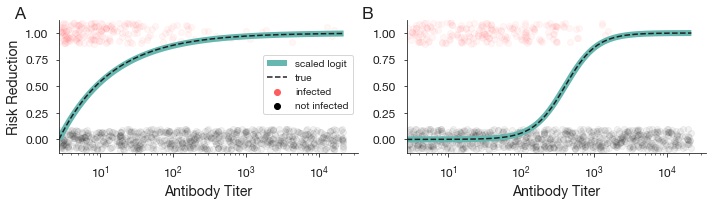

In [212]:
data_gen_functions = ["exponential","sigmoid"]
function_error_dict = {}

figure_mosaic = """
AB
"""
fig_labs = ["A","B"]

fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic,figsize=(10,3))

for ii,gen_func in enumerate(data_gen_functions):
    # Showing how standard logistic regression estimates risk
    param_dict = get_params_for_link_function(gen_func)
    TND = generate_TND_data(N,gen_func,protection_params=param_dict)
    Ab_logged = TND[0]; infected = TND[1]
    Ab_unlogged = np.exp(Ab_logged)
    Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
    infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

    # Use logistic regression to estimate risk 
    potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
    potential_Abs_unlogged = np.exp(potential_Abs_logged)
    inf_probs = fit_logistic_regression(Ab_logged,infected,potential_Abs_logged)
    RR_estimate = one_minus_OR(inf_probs)

    # Fit scaled logistic
    fitted_params = fit_scaled_logistic(Ab_logged,infected)
    # Extract fitted parameters and plug in
    fitted_k, fitted_beta_0, fitted_beta_1 = fitted_params
    inf_probs_scaled = scaled_logistic(potential_Abs_logged, fitted_k, fitted_beta_0, fitted_beta_1)
    RR_estimate_scaled = one_minus_OR(inf_probs_scaled)

    # Calculate estimated and simulated VE
    exec(f"X = {gen_func}") 
    p1,p2 = list(param_dict.values())
    RR_simulated = [X(Ab,p1,p2) for Ab in potential_Abs_logged]

    # Plot a single simulation for each data generating function
    ax = axes[fig_labs[ii]]
    ax.scatter(Ab_unlogged_samples[infected_samples > 0.5], infected_samples[infected_samples > 0.5], c=inf_color, alpha=0.05,label="infected")
    ax.scatter(Ab_unlogged_samples[infected_samples < 0.5], infected_samples[infected_samples < 0.5], c="k" ,alpha=0.05,label="not infected")
    # estimate_standard = ax.plot(potential_Abs,inf_probs,c=logistic_color,label="logistic",linewidth=6)
    estimated = ax.plot(potential_Abs_unlogged,RR_estimate_scaled,c=scaled_logit_color,label="scaled logit",linewidth=6)
    simulated = ax.plot(potential_Abs_unlogged,RR_simulated,c=ALMOST_BLACK,linestyle="dashed",label="true")
    # ax.set_title(gen_func)
    hide_right_top_axis(ax)
    ax.set_ylim([-0.125,1.125])

axes["A"].set_ylabel("Risk Reduction")   
axes["A"].set_xlabel("Antibody Titer")
axes["B"].set_xlabel("Antibody Titer")

leg = axes["A"].legend(bbox_to_anchor=(1,0.25),loc="lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

xpad = -0.15; ypad = 1.1
label_subplots(axes,[xpad,xpad,xpad,xpad], y_pad=ypad, labels=fig_labs)

ax_labs = ["A","B"]
for ax_lab in ax_labs:
    axes[ax_lab].set_xscale('log')
    axes[ax_lab].set_xlim([min(Ab_unlogged),None])
    finalize(axes[ax_lab])

# Show the plot
plt.grid(False)
plt.tight_layout()
plt.savefig("figs/Fig3.jpg",dpi=300,bbox_inches='tight')
plt.show()

In [28]:
def calc_proportion_infected(Ab_titers, infected, num_bins=20):
    # Define log-space bins
    min_titer = np.min(Ab_titers)
    max_titer = np.max(Ab_titers)
    bins = np.linspace(min_titer, max_titer, num_bins + 1)
    
    # Initialize array to store the proportion infected
    prop_infected = np.zeros(num_bins)
    
    # Calculate the proportion infected within each bin
    for i in range(num_bins):
        in_bin = (Ab_titers >= bins[i]) & (Ab_titers < bins[i + 1])
        if np.sum(in_bin) > 0:
            prop_infected[i] = np.sum(infected[in_bin]) / np.sum(in_bin)
    
    # Return the bin centers and proportions
    bin_centers = (bins[:-1] + bins[1:]) / 2
    return bin_centers, prop_infected

# Example usage:
# Ab_titers = np.array([...])
# infected = np.array([...])
# bin_centers, prop_infected = calc_proportion_infected(Ab_titers, infected)


[ 1.          1.82936073 -0.4053335 ]
[ 0.64202783 13.28376363 -2.02893492]


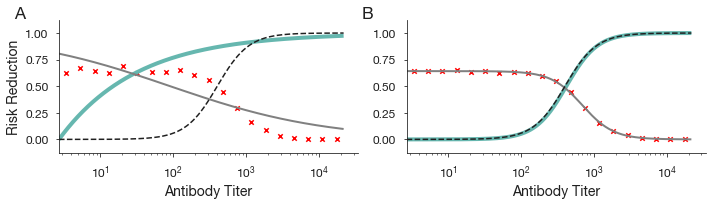

In [95]:
n_its = 1
cpc = 1
gen_func = "sigmoid"
param_dict = get_params_for_link_function(gen_func)
N_vals = [10000,100000]

figure_mosaic = """
AB
"""
fig_labs = ["A","B"]

fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic,figsize=(10,3))

for ii,N_i in enumerate(N_vals):
    ax = axes[fig_labs[ii]]

    for it in range(n_its):
    # Showing how standard logistic regression estimates risk
        TND = generate_TND_data(N_i,gen_func,protection_params=param_dict,controls_per_case=cpc)
        Ab_logged = TND[0]; infected = TND[1]
        Ab_unlogged = np.exp(Ab_logged)
        Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
        infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

        # Use logistic regression to estimate risk 
        potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
        potential_Abs_unlogged = np.exp(potential_Abs_logged)
        inf_probs = fit_logistic_regression(Ab_logged,infected,potential_Abs_logged)
        RR_estimate = one_minus_OR(inf_probs)

        # Fit scaled logistic
        fitted_params = fit_scaled_logistic(Ab_logged,infected)
        print(fitted_params)
        # Extract fitted parameters and plug in
        fitted_k, fitted_beta_0, fitted_beta_1 = fitted_params
        inf_probs_scaled = scaled_logistic(potential_Abs_logged, fitted_k, fitted_beta_0, fitted_beta_1)
        RR_estimate_scaled = one_minus_OR(inf_probs_scaled)

        estimated = ax.plot(potential_Abs_unlogged,RR_estimate_scaled,c=scaled_logit_color,label="scaled logit",linewidth=4)#1,alpha=0.5)
        ax.plot(potential_Abs_unlogged,inf_probs_scaled,c="gray",label="scaled logit",linewidth=2)#1,alpha=0.5)

        # get true proportion infected
        bin_centers, prop_inf = calc_proportion_infected(Ab_logged,infected)
        ax.scatter(np.exp(bin_centers),prop_inf,c="r",marker="x",s=20)
    
    # Calculate estimated and simulated VE
    exec(f"X = {gen_func}") 
    p1,p2 = list(param_dict.values())
    RR_simulated = [X(Ab,p1,p2) for Ab in potential_Abs_logged]
    simulated = ax.plot(potential_Abs_unlogged,RR_simulated,c=ALMOST_BLACK,linestyle="dashed",label="true")
    # ax.set_title(gen_func)
    hide_right_top_axis(ax)
    ax.set_ylim([-0.125,1.125])

axes["A"].set_ylabel("Risk Reduction")   
axes["A"].set_xlabel("Antibody Titer")
axes["B"].set_xlabel("Antibody Titer")

xpad = -0.15; ypad = 1.1
label_subplots(axes,[xpad,xpad,xpad,xpad], y_pad=ypad, labels=fig_labs)

ax_labs = ["A","B"]
for ax_lab in ax_labs:
    axes[ax_lab].set_xscale('log')
    axes[ax_lab].set_xlim([min(Ab_unlogged),None])
    finalize(axes[ax_lab])

# Show the plot
plt.grid(False)
plt.tight_layout()
plt.show()

CTC = 1 pushed the true value of lambda higher, and the model seems to randomly default to an exponential sometimes in this case even at high sample sizes

Supp Fig: comparing logistic vs scaled logit for 4 functional forms

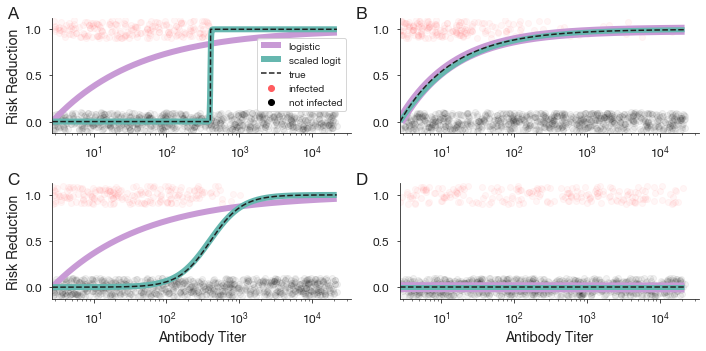

In [18]:
data_gen_functions = ["threshold","exponential","sigmoid","no_relationship"]
function_error_dict = {}

figure_mosaic = """
AB
CD
"""
fig_labs = ["A","B","C","D"]

fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic,figsize=(10,5))

for ii,gen_func in enumerate(data_gen_functions):
    # Showing how standard logistic regression estimates risk
    param_dict = get_params_for_link_function(gen_func)
    TND = generate_TND_data(N,gen_func,protection_params=param_dict)
    Ab_logged = TND[0]; infected = TND[1]
    Ab_unlogged = np.exp(Ab_logged)
    Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
    infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

    # Use logistic regression to estimate risk 
    potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
    potential_Abs_unlogged = np.exp(potential_Abs_logged)
    inf_probs = fit_logistic_regression(Ab_logged,infected,potential_Abs_logged)
    RR_estimate = one_minus_OR(inf_probs)

    # Fit scaled logistic
    fitted_params = fit_scaled_logistic(Ab_logged,infected)
    # Extract fitted parameters and plug in
    fitted_k, fitted_beta_0, fitted_beta_1 = fitted_params
    inf_probs_scaled = scaled_logistic(potential_Abs_logged, fitted_k, fitted_beta_0, fitted_beta_1)
    RR_estimate_scaled = one_minus_OR(inf_probs_scaled)

    # Calculate estimated and simulated VE
    if gen_func != "no_relationship":
        exec(f"X = {gen_func}") 
        p1,p2 = list(param_dict.values())
        RR_simulated = X(potential_Abs_logged,p1,p2)
    else:
        RR_simulated = no_relationship(potential_Abs_logged)

    # Plot a single simulation for each data generating function
    ax = axes[fig_labs[ii]]
    ax.scatter(Ab_unlogged_samples[infected_samples > 0.5], infected_samples[infected_samples > 0.5], c=inf_color, alpha=0.05,label="infected")
    ax.scatter(Ab_unlogged_samples[infected_samples < 0.5], infected_samples[infected_samples < 0.5], c="k" ,alpha=0.05,label="not infected")
    if gen_func in ["exponential","no_relationship"]:
        # change line widths when they will be overlapping
        estimate_standard = ax.plot(potential_Abs_unlogged,RR_estimate,c=logistic_color,label="logistic",linewidth=10)
        estimate_scaled = ax.plot(potential_Abs_unlogged,RR_estimate_scaled,c=scaled_logit_color,label="scaled logit",linewidth=5)
    else:
        estimate_standard = ax.plot(potential_Abs_unlogged,RR_estimate,c=logistic_color,label="logistic",linewidth=6)
        estimate_scaled = ax.plot(potential_Abs_unlogged,RR_estimate_scaled,c=scaled_logit_color,label="scaled logit",linewidth=6)
    simulated = ax.plot(potential_Abs_unlogged,RR_simulated,c=ALMOST_BLACK,linestyle="dashed",label="true")
    # ax.set_title(gen_func)
    hide_right_top_axis(ax)
    ax.set_ylim([-0.125,1.125])

axes["A"].set_ylabel("Risk Reduction")   
axes["C"].set_ylabel("Risk Reduction")   
axes["C"].set_xlabel("Antibody Titer")
axes["D"].set_xlabel("Antibody Titer")

leg = axes["A"].legend(bbox_to_anchor=(1,0.15),loc="lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

xpad = -0.15; ypad = 1.1
label_subplots(axes,[xpad,xpad,xpad,xpad], y_pad=ypad, labels=fig_labs)

ax_labs = ["A","B","C","D"]
for ax_lab in ax_labs:
    axes[ax_lab].set_xscale('log')
    axes[ax_lab].set_xlim([min(Ab_unlogged),None])
    finalize(axes[ax_lab])

# Show the plot
plt.grid(False)
plt.tight_layout()
plt.savefig("figs/Fig3Supp.jpg",dpi=300,bbox_inches='tight')
plt.show()

# Fig 4
Case-to-control ratio & sample sizes

In [32]:
n_iterations = 50 # Note: this takes about 13 hrs to run with 100 iterations. Decrease size for faster run
gen_func = "sigmoid"
control_per_case_vals = [4,9,19,29,39,49]
num_samples = np.arange(1000,50100,1000)
max_err = 0

error_matrix = []
for ii,cpc in enumerate(control_per_case_vals):
    error_vec = []
    for N_i in num_samples:
        iteration_errors = []
        for iteration in range(n_iterations):
            # Showing how standard logistic regression estimates risk
            param_dict = get_params_for_link_function(gen_func)
            TND = generate_TND_data(N_i,gen_func,protection_params=param_dict,controls_per_case=cpc)
            Ab_logged = TND[0]; infected = TND[1]
            Ab_unlogged = np.exp(Ab_logged)
            Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
            infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

            # # Use better inital guess for k
            # # calculate initial guess for k
            # Ab_logged_positive = Ab_logged[infected == 1]
            # k_est = np.sum(Ab_logged_positive < 0.25) / (np.sum(Ab_logged < 0.25) - np.sum(Ab_logged_positive < 0.25))
            # initial_guess = (k_est,1,-1)

            # Fit scaled logistic
            potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
            potential_Abs_unlogged = np.exp(potential_Abs_logged)
            fitted_params = fit_scaled_logistic(Ab_logged,infected)
            # Extract fitted parameters and plug in
            fitted_k, fitted_beta_0, fitted_beta_1 = fitted_params
            inf_probs_scaled = scaled_logistic(potential_Abs_logged, fitted_k, fitted_beta_0, fitted_beta_1)
            RR_estimate_scaled = one_minus_OR(inf_probs_scaled)

            # Calculate estimated and simulated VE
            if gen_func != "no_relationship":
                exec(f"X = {gen_func}") 
                p1,p2 = list(param_dict.values())
                RR_simulated = X(potential_Abs_logged,p1,p2)
            else:
                RR_simulated = no_relationship(potential_Abs_logged)

            # Calculate iteration error
            it_error = get_L2_norm_error(RR_estimate_scaled,RR_simulated)
            if it_error > 7:
                print("flagging N = {}, CTC = {}".format(N_i,cpc))
                print(fitted_params)
            iteration_errors.append(it_error)
            
        # Calculate average simulation error
        error_vec.append(np.mean(iteration_errors))

    # Save average L2 norm errors for all samples in this case:control scenario
    error_matrix.append(error_vec)

# Write data to CSV
with open("data/Error_sample_size_scaled_logit.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(error_matrix)

flagging N = 1000, CTC = 19
[ 7.44047633e-02  4.37522543e+04 -6.33987407e+03]
flagging N = 1000, CTC = 19
[ 6.91562963e-02  2.75724184e+04 -3.92645709e+03]
flagging N = 1000, CTC = 19
[ 0.18002752  2.74087645 -0.83244683]
flagging N = 1000, CTC = 29
[ 0.14736906  2.50778139 -0.85705103]
flagging N = 1000, CTC = 39
[ 0.06374581  5.61555293 -1.24098807]
flagging N = 1000, CTC = 39
[ 3.66032212e-02  7.03834192e+04 -9.85135254e+03]
flagging N = 1000, CTC = 39
[ 3.68731559e-02  1.13067405e+05 -1.65303528e+04]
flagging N = 1000, CTC = 39
[ 3.84615385e-02  4.86179712e+04 -7.09811218e+03]
flagging N = 1000, CTC = 39
[ 3.58166188e-02  2.96066417e+05 -4.21391822e+04]
flagging N = 1000, CTC = 39
[ 0.06749452  4.67089397 -1.04271663]
flagging N = 1000, CTC = 39
[ 3.88198761e-02  2.99663531e+04 -4.35512181e+03]
flagging N = 3000, CTC = 39
[ 3.68007850e-02  2.30897052e+05 -3.26736225e+04]
Did not find optimal parameter fit to minimize likelihood
flagging N = 1000, CTC = 49
[ 0.04909172  6.02891076 -

In [ ]:
n_iterations = 50
gen_func = "sigmoid"
control_per_case_vals = [4,9,19,29,39,49]
num_samples = np.arange(1000,50100,1000)
max_err = 0

error_matrix = []
for ii,cpc in enumerate(control_per_case_vals):
    error_vec = []
    for N_i in num_samples:
        iteration_errors = []
        for iteration in range(n_iterations):
            # Showing how standard logistic regression estimates risk
            param_dict = get_params_for_link_function(gen_func)
            TND = generate_TND_data(N_i,gen_func,protection_params=param_dict,controls_per_case=cpc)
            Ab_logged = TND[0]; infected = TND[1]
            Ab_unlogged = np.exp(Ab_logged)
            Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
            infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

            # Use logistic regression to estimate risk 
            potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
            potential_Abs_unlogged = np.exp(potential_Abs_logged)
            inf_probs = fit_logistic_regression(Ab_logged,infected,potential_Abs_logged)
            RR_estimate = one_minus_OR(inf_probs)

            # Calculate estimated and simulated VE
            if gen_func != "no_relationship":
                exec(f"X = {gen_func}") 
                p1,p2 = list(param_dict.values())
                RR_simulated = X(potential_Abs_logged,p1,p2)
            else:
                RR_simulated = no_relationship(potential_Abs_logged)

            # Calculate iteration error
            it_error = get_L2_norm_error(RR_estimate,RR_simulated)
            iteration_errors.append(it_error)
            
        # Calculate average simulation error
        error_vec.append(np.mean(iteration_errors))

    # Save average L2 norm errors for all samples in this case:control scenario
    error_matrix.append(error_vec)

# Write data to CSV
with open("data/Error_sample_size_logistic.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(error_matrix)

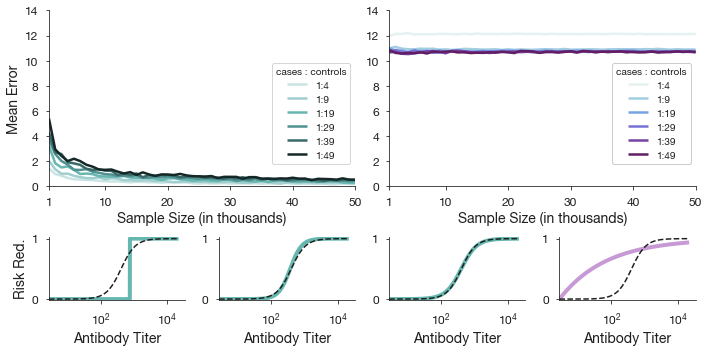

In [ ]:
figure_mosaic = """
AABB
AABB
1234
"""
ax_labs = ["1","2","3","4","A","B"]
fig_labs = ["A","B","I.","II.","III.","IV."]

fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic,figsize=(10,5))

control_per_case_vals = [1,9,19,29,39,49]
num_samples = np.arange(1000,50100,1000)

# Top panels: Examles of error ----------------------------------------------
cpc = 49
sample_N_vals = [1000,10000,40000]

for ii,N_i in enumerate(sample_N_vals):
    ax = axes[ax_labs[ii]]
    param_dict = get_params_for_link_function(gen_func)
    TND = generate_TND_data(sample_N_vals[ii],gen_func,protection_params=param_dict,controls_per_case=cpc)
    Ab_logged = TND[0]; infected = TND[1]
    Ab_unlogged = np.exp(Ab_logged)
    Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
    infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

    # Use logistic regression to estimate risk 
    potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
    potential_Abs_unlogged = np.exp(potential_Abs_logged)
    inf_probs = fit_logistic_regression(Ab_logged,infected,potential_Abs_logged)
    RR_estimate = one_minus_OR(inf_probs)

    # Fit scaled logistic
    fitted_params = fit_scaled_logistic(Ab_logged,infected)
    # Extract fitted parameters and plug in
    fitted_k, fitted_beta_0, fitted_beta_1 = fitted_params
    inf_probs_scaled = scaled_logistic(potential_Abs_logged, fitted_k, fitted_beta_0, fitted_beta_1)
    RR_estimate_scaled = one_minus_OR(inf_probs_scaled)

    # Calculate estimated and simulated VE
    exec(f"X = {gen_func}") 
    p1,p2 = list(param_dict.values())
    RR_simulated = X(potential_Abs_logged,p1,p2)

    estimate_scaled = ax.plot(potential_Abs_unlogged,RR_estimate_scaled,c=scaled_logit_color,label="scaled logit",linewidth=4)    
    simulated = ax.plot(potential_Abs_unlogged,RR_simulated,c=ALMOST_BLACK,linestyle="dashed",label="true")
    hide_right_top_axis(ax)
    ax.set_ylim([-0.01,1.03])
    ax.set_xlabel("Antibody Titer")
    ax.set_xscale('log')
    ax.set_xlim([min(Ab_unlogged),None])
    finalize(ax)


# One sample of logistic regression
ax = axes["4"]
# Showing how standard logistic regression estimates risk
param_dict = get_params_for_link_function(gen_func)
TND = generate_TND_data(sample_N_vals[-1],gen_func,protection_params=param_dict,controls_per_case=cpc)
Ab_logged = TND[0]; infected = TND[1]
Ab_unlogged = np.exp(Ab_logged)
Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

# Use logistic regression to estimate risk 
potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
potential_Abs_unlogged = np.exp(potential_Abs_logged)
inf_probs = fit_logistic_regression(Ab_logged,infected,potential_Abs_logged)
RR_estimate = one_minus_OR(inf_probs)

# Calculate simulated VE
exec(f"X = {gen_func}") 
p1,p2 = list(param_dict.values())
RR_simulated = X(potential_Abs_logged,p1,p2)

estimate_scaled = ax.plot(potential_Abs_unlogged,RR_estimate,c=logistic_color,label="logistic regression",linewidth=4)    
simulated = ax.plot(potential_Abs_unlogged,RR_simulated,c=ALMOST_BLACK,linestyle="dashed",label="true")
hide_right_top_axis(ax)
ax.set_ylim([-0.01,1.03]) 
ax.set_xlabel("Antibody Titer")
ax.set_xscale('log')
ax.set_xlim([min(Ab_unlogged),None])
finalize(ax)

axes["1"].set_ylabel("Risk Red.")  

# Panel A: scaled logit model ----------------------------------------------

ax = axes['A']
# Read data from CSV
with open("data/Error_sample_size_scaled_logit.csv", "r") as f:
    reader = csv.reader(f)
    error_matrix = [np.float_(row) for row in reader]

error_vec_ctc_1 = error_matrix[0]
error_vec_ctc_10 = error_matrix[1]
error_vec_ctc_20 = error_matrix[2]
error_vec_ctc_30 = error_matrix[3]
error_vec_ctc_40 = error_matrix[4]
error_vec_ctc_50 = error_matrix[5]
color_vec = ["#152828","#3A6969","#509191","#68B6B0","#A1CECE","#CAE3E3"]
# from palettable.cmocean.sequential import Tempo_7 as color_vec

# Plot error values for each N at this case:control ratio
lw = 2.5
ax.plot(num_samples, error_vec_ctc_1, c=color_vec[5],label="1:4", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_10, c=color_vec[4],label="1:9", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_20, c=color_vec[3],label="1:19", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_30, c=color_vec[2],label="1:29", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_40, c=color_vec[1],label="1:39", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_50, c=color_vec[0],label="1:49", linewidth=lw)


# dx = 250; dy = 0.1
# ax.text(1000+dx*2,error_vec_ctc_50[0]-0.2,"I.",size=LABEL_SIZE)
# ax.text(8000+dx,error_vec_ctc_50[7],"II.",size=LABEL_SIZE)
# ax.text(30000+dx,error_vec_ctc_50[29]+dy,"III.",size=LABEL_SIZE)

# ax.set_xlabel("Sample Size (in thousands)")
ax.set_ylabel("Mean Error")
ax.legend(title="cases : controls", bbox_to_anchor=(1,0.1),loc="lower right")


# Panel B: logistic regression ----------------------------------------------

ax = axes['B']
# Read data from CSV
with open("data/Error_sample_size_logistic.csv", "r") as f:
    reader = csv.reader(f)
    error_matrix = [np.float_(row) for row in reader]

error_vec_ctc_1 = error_matrix[0]
error_vec_ctc_10 = error_matrix[1]
error_vec_ctc_20 = error_matrix[2]
error_vec_ctc_30 = error_matrix[3]
error_vec_ctc_40 = error_matrix[4]
error_vec_ctc_50 = error_matrix[5]
from palettable.cmocean.sequential import Dense_7 as color_vec
color_vec = color_vec.hex_colors
#from palettable.Colorbrewer.sequential import Purples_7 as color_vec #PuRd_7, 

# Plot error values for each N at this case:control ratio
lw = 2.5
ax.plot(num_samples, error_vec_ctc_1, c=color_vec[0],label="1:4", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_10, c=color_vec[1],label="1:9", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_20, c=color_vec[2],label="1:19", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_30, c=color_vec[3],label="1:29", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_40, c=color_vec[4],label="1:39", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_50, c=color_vec[5],label="1:49", linewidth=lw)

# ax.text(30000+dx,error_vec_ctc_50[29]-dy*3,"IV.",size=LABEL_SIZE)

hide_right_top_axis(ax)
# ax.set_ylabel("Mean Error")
ax.legend(title="cases : controls", bbox_to_anchor=(1,0.1),loc="lower right",framealpha=1)

for ax_lab in ["A","B"]:
    ax = axes[ax_lab]
    ax.set_xlabel("Sample Size (in thousands)")
    ax.set_xlim([1000,50000]); 
    ax.set_xticks([1000,10000,20000,30000,40000,50000]); ax.set_xticklabels([1,10,20,30,40,50])
    ax.set_ylim([0,14])
    finalize(ax)

# Show the plot
plt.grid(False)
plt.tight_layout()
fig.subplots_adjust(hspace=0.8,wspace=0.25) # space between columns, rows
plt.savefig("figs/raw/Fig4_raw.jpg",dpi=300,bbox_inches='tight')
plt.show()

What about samples < 1000?

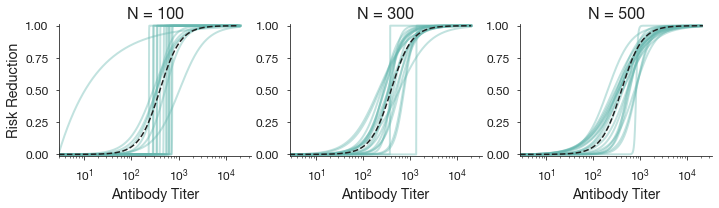

In [61]:
N_vals = [100,300,500]
cpc = 4
n_iterations = 20
gen_func = "sigmoid"

figure_mosaic = """
ABC
"""
fig_labs = ["A","B","C"]

fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic,figsize=(10,3))

for ii,N_i in enumerate(N_vals):
    ax = axes[fig_labs[ii]]
    for jj in range(n_iterations):
        param_dict = get_params_for_link_function(gen_func)
        TND = generate_TND_data(N_i,gen_func,protection_params=param_dict)
        Ab_logged = TND[0]; infected = TND[1]
        Ab_unlogged = np.exp(Ab_logged)
        Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
        infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

        # Fit scaled logistic
        potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
        potential_Abs_unlogged = np.exp(potential_Abs_logged)
        fitted_params = fit_scaled_logistic(Ab_logged,infected)
        # Extract fitted parameters and plug in
        fitted_k, fitted_beta_0, fitted_beta_1 = fitted_params
        inf_probs_scaled = scaled_logistic(potential_Abs_logged, fitted_k, fitted_beta_0, fitted_beta_1)
        RR_estimate_scaled = one_minus_OR(inf_probs_scaled)

        estimate_scaled = ax.plot(potential_Abs_unlogged,RR_estimate_scaled,c=scaled_logit_color,label="scaled logit",linewidth=2,alpha=0.4)        
    
    # Calculate simulated VE
    exec(f"X = {gen_func}") 
    p1,p2 = list(param_dict.values())
    RR_simulated = X(potential_Abs_logged,p1,p2)
    simulated = ax.plot(potential_Abs_unlogged,RR_simulated,c=ALMOST_BLACK,linestyle="dashed",label="true")
    
    hide_right_top_axis(ax)
    ax.set_ylim([-0.01,1.01])
    ax.set_xlabel("Antibody Titer")
    ax.set_title("N = {}".format(N_i),size=LABEL_SIZE+2)
    ax.set_xscale('log')
    ax.set_xlim([min(Ab_unlogged),None])
    finalize(ax)

axes["A"].set_ylabel("Risk Reduction")

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig("figs/low_sample_size.jpg",dpi=300,bbox_inches='tight')
plt.show()

In [104]:
n_iterations = 50
gen_func = "sigmoid"
control_per_case_vals = [4,9,19,29,39,49]
num_samples = np.arange(100,1100,100)
max_err = 0

error_matrix = []
for ii,cpc in enumerate(control_per_case_vals):
    error_vec = []
    for N_i in num_samples:
        iteration_errors = []
        for iteration in range(n_iterations):
            # Showing how standard logistic regression estimates risk
            param_dict = get_params_for_link_function(gen_func)
            TND = generate_TND_data(N_i,gen_func,protection_params=param_dict,controls_per_case=cpc)
            Ab_logged = TND[0]; infected = TND[1]
            Ab_unlogged = np.exp(Ab_logged)
            Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
            infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

            # Fit scaled logistic
            potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
            potential_Abs_unlogged = np.exp(potential_Abs_logged)
            fitted_params = fit_scaled_logistic(Ab_logged,infected)
            # Extract fitted parameters and plug in
            fitted_k, fitted_beta_0, fitted_beta_1 = fitted_params
            inf_probs_scaled = scaled_logistic(potential_Abs_logged, fitted_k, fitted_beta_0, fitted_beta_1)
            RR_estimate_scaled = one_minus_OR(inf_probs_scaled)

            # Calculate estimated and simulated VE
            if gen_func != "no_relationship":
                exec(f"X = {gen_func}") 
                p1,p2 = list(param_dict.values())
                RR_simulated = X(potential_Abs_logged,p1,p2)
            else:
                RR_simulated = no_relationship(potential_Abs_logged)

            # Calculate iteration error
            it_error = get_L2_norm_error(RR_estimate_scaled,RR_simulated)
            iteration_errors.append(it_error)
            
        # Calculate average simulation error
        error_vec.append(np.mean(iteration_errors))

    # Save average L2 norm errors for all samples in this case:control scenario
    error_matrix.append(error_vec)

# Write data to CSV
with open("data/Fig4Supp_low_sample_size.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(error_matrix)

Did not find optimal parameter fit to minimize likelihood
Did not find optimal parameter fit to minimize likelihood
Did not find optimal parameter fit to minimize likelihood
Did not find optimal parameter fit to minimize likelihood
Did not find optimal parameter fit to minimize likelihood
Did not find optimal parameter fit to minimize likelihood


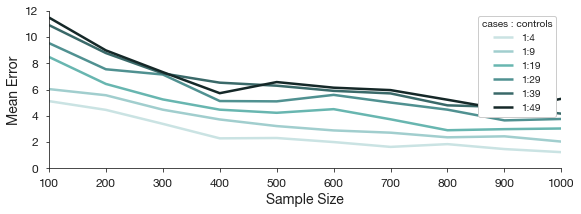

In [105]:
control_per_case_vals = [4,9,19,29,39,49]
num_samples = np.arange(100,1100,100)

# Read data from CSV
with open("data/Fig4Supp_low_sample_size.csv", "r") as f:
    reader = csv.reader(f)
    error_matrix = [np.float_(row) for row in reader]


fig, ax = plt.subplots(figsize=(8,3))

error_vec_ctc_1 = error_matrix[0]
error_vec_ctc_10 = error_matrix[1]
error_vec_ctc_20 = error_matrix[2]
error_vec_ctc_30 = error_matrix[3]
error_vec_ctc_40 = error_matrix[4]
error_vec_ctc_50 = error_matrix[5]
color_vec = ["#152828","#3A6969","#509191","#68B6B0","#A1CECE","#CAE3E3"]
# from palettable.cmocean.sequential import Tempo_7 as color_vec

# Plot error values for each N at this case:control ratio
lw = 2.5
ax.plot(num_samples, error_vec_ctc_1, c=color_vec[5],label="1:4", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_10, c=color_vec[4],label="1:9", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_20, c=color_vec[3],label="1:19", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_30, c=color_vec[2],label="1:29", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_40, c=color_vec[1],label="1:39", linewidth=lw)
ax.plot(num_samples, error_vec_ctc_50, c=color_vec[0],label="1:49", linewidth=lw)

hide_right_top_axis(ax)
ax.set_xlabel("Sample Size")
ax.set_ylabel("Mean Error")
# ax.set_xticks(num_samples); ax.set_xticklabels([1,10,20,30,40,50])
ax.legend(title="cases : controls",framealpha=1)
ax.set_xlim([100,1000]); ax.set_ylim([0,12])

# Show the plot
plt.grid(False)
plt.tight_layout()
finalize(ax)
plt.savefig("figs/Fig4Supp_lowSS.jpg",dpi=300,bbox_inches='tight')
plt.show()

# Fig 5
What if protection does not saturate to 1?

In [57]:
def get_sigmoid_steepness_for_unsampled_saturation(midpoint,max_saturation,max_sample):
    '''
    Sometimes we want to simulate a protection function that saturates, but we only sample
    imperfect protection in our data. This function calculates the slope needed for a given 
    midpoint, max_sample, and max_saturation value.
    '''
    if max_saturation < 1:
        return -math.log(1/max_saturation - 1)/(max_sample - midpoint)
    else:
        return 2

In [92]:
def get_params_for_link_function_non_saturating(link_function):
    ''' Returns parameters for protection link function in the order in which they are passed '''
    if link_function == "non_saturating":
        param_dict = {"steepness": 2, "mid_point": 6, "saturating_point":0.65}
        return param_dict
    elif link_function == "no_sampled_perfect_protections":
        midpoint = 9
        steepness = get_sigmoid_steepness_for_unsampled_saturation(midpoint,0.65,10)
        param_dict = {"steepness": steepness, "mid_point": midpoint}
        return param_dict
    else:
        raise ValueError(f"Invalid relationship type: {link_function}")

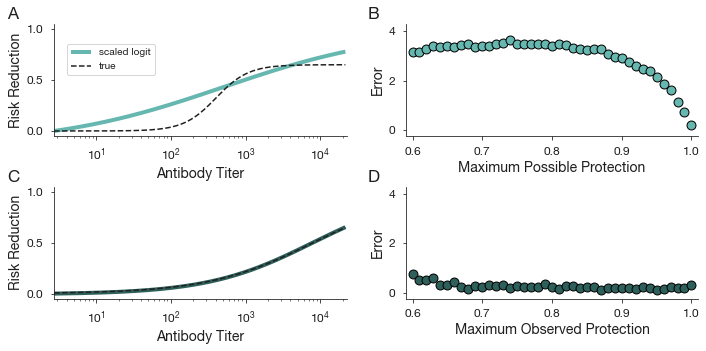

In [ ]:
data_gen_functions = ["non_saturating","no_sampled_perfect_protections"]
cols = [scaled_logit_color,dark_scaled_logit_color]
max_err = 0

figure_mosaic = """
AC
BD
"""
fig_labs = ["A","B","C","D"]

fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic,figsize=(10,5))

for ii,gen_func in enumerate(data_gen_functions):
    # Showing how standard logistic regression estimates risk
    param_dict = get_params_for_link_function_non_saturating(gen_func)
    TND = generate_TND_data(N,"sigmoid",protection_params=param_dict)
    Ab_logged = TND[0]; infected = TND[1]
    Ab_unlogged = np.exp(Ab_logged)
    Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
    infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

    potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
    potential_Abs_unlogged = np.exp(potential_Abs_logged)

    # Fit scaled logistic
    fitted_params = fit_scaled_logistic(Ab_logged,infected)
    # Extract fitted parameters and plug in
    fitted_k, fitted_beta_0, fitted_beta_1 = fitted_params
    inf_probs_scaled = scaled_logistic(potential_Abs_logged, fitted_k, fitted_beta_0, fitted_beta_1)
    RR_estimate_scaled = one_minus_OR(inf_probs_scaled)

    # Get simulated VE 
    try:
        p1,p2,p3 = list(param_dict.values())
    except:
        p1,p2 = list(param_dict.values())
        p3 = 1
    RR_simulated = sigmoid(potential_Abs_logged,p1,p2,p3)

    # Plot a single simulation for each data generating function
    ax = axes[fig_labs[ii]]
    # ax.scatter(Ab_unlogged_samples[infected_samples > 0.5], infected_samples[infected_samples > 0.5], c=inf_color, alpha=0.05, label="infected")
    # ax.scatter(Ab_unlogged_samples[infected_samples < 0.5], infected_samples[infected_samples < 0.5], c="k" ,alpha=0.05, label="not infected")
    estimate_scaled = ax.plot(potential_Abs_unlogged,RR_estimate_scaled,c=cols[ii],label="scaled logit",linewidth=4)    
    simulated = ax.plot(potential_Abs_unlogged,RR_simulated,c=ALMOST_BLACK,linestyle="dashed",label="true")
    hide_right_top_axis(ax)
    ax.set_xlim([min(potential_Abs_unlogged),None])
    ax.set_ylim([-0.05,1.05])
    ax.set_ylabel("Risk Reduction") 
    ax.set_xlabel("Antibody Titer")
    ax.set_xscale('log')
    finalize(ax)


leg = axes["A"].legend(bbox_to_anchor=(0.36,0.5),loc="lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax_labs = ["A","B"]
for ax_lab in ax_labs:
    # axes[ax_lab].plot([0,3000],[0.75,0.75],c="gray",linestyle="dotted",alpha=0.5)
    finalize(axes[ax_lab])
    
# Plots varing saturation points -----------------------------------------------
data_gen_functions = ["non_saturating","no_sampled_perfect_protections"]
saturating_points = np.arange(0.6,1.01,0.01)
slopes = [get_sigmoid_steepness_for_unsampled_saturation(9,sat_pt,10) for sat_pt in saturating_points]
n_iterations = 5

ax = axes["C"]
for saturating_point in saturating_points:
    it_errs = []
    for j in range(n_iterations):
        gen_func = data_gen_functions[0]
        # Showing how standard logistic regression estimates risk
        param_dict = get_params_for_link_function_non_saturating(gen_func)
        param_dict['saturating_point'] = saturating_point
        TND = generate_TND_data(N,"sigmoid",protection_params=param_dict)
        Ab_logged = TND[0]; infected = TND[1]
        Ab_unlogged = np.exp(Ab_logged)
        Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
        infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

        # Fit scaled logistic
        potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
        potential_Abs_unlogged = np.exp(potential_Abs_logged)
        fitted_params = fit_scaled_logistic(Ab_logged,infected)
        # Extract fitted parameters and plug in
        fitted_k, fitted_beta_0, fitted_beta_1 = fitted_params
        inf_probs_scaled = scaled_logistic(potential_Abs_logged, fitted_k, fitted_beta_0, fitted_beta_1)
        RR_estimate_scaled = one_minus_OR(inf_probs_scaled)

        # Get simulated VE 
        p1,p2,p3 = list(param_dict.values())
        RR_simulated = sigmoid(potential_Abs_logged,p1,p2,p3)

        # Get error
        it_errs.append(get_L2_norm_error(RR_estimate_scaled,RR_simulated))

    # Plot a single simulation for each data generating function
    err = np.mean(it_errs)
    ax.scatter(saturating_point, err, c=scaled_logit_color, edgecolor="k", s=80)

ax = axes["D"]
for ii,slope in enumerate(slopes):
    it_errs = []
    for j in range(n_iterations):
        gen_func = data_gen_functions[1]
        # Showing how standard logistic regression estimates risk
        param_dict = get_params_for_link_function_non_saturating(gen_func)
        param_dict['steepness'] = slope
        TND = generate_TND_data(N,"sigmoid",protection_params=param_dict)
        Ab_logged = TND[0]; infected = TND[1]
        Ab_unlogged = np.exp(Ab_logged)
        Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
        infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

        # Fit scaled logistic
        potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
        potential_Abs_unlogged = np.exp(potential_Abs_logged)
        fitted_params = fit_scaled_logistic(Ab_logged,infected)
        # Extract fitted parameters and plug in
        fitted_k, fitted_beta_0, fitted_beta_1 = fitted_params
        inf_probs_scaled = scaled_logistic(potential_Abs_logged, fitted_k, fitted_beta_0, fitted_beta_1)
        RR_estimate_scaled = one_minus_OR(inf_probs_scaled)

        # Get simulated VE 
        p1,p2 = list(param_dict.values())
        p3 = 1
        RR_simulated = sigmoid(potential_Abs_logged,p1,p2,p3)

        # Get error
        it_errs.append(get_L2_norm_error(RR_estimate_scaled,RR_simulated))

    # Plot a single simulation for each data generating function
    err = np.mean(it_errs)
    ax.scatter(saturating_points[ii], err, c=dark_scaled_logit_color, edgecolor="k", s=80)

for ax_lab in ["C","D"]:
    ax = axes[ax_lab]
    hide_right_top_axis(ax)
    ax.set_xlim([0.59,1.01])
    ax.set_ylim([-0.25,4.3])
    ax.set_ylabel("Error")   
    finalize(ax)

# axes["A"].set_title("Non-Saturating Protection Function",size=LABEL_SIZE+2)
# axes["B"].set_title("Perfect Protection Not Sampled",size=LABEL_SIZE+2)
axes["C"].set_xlabel("Maximum Possible Protection")
axes["D"].set_xlabel("Maximum Observed Protection")

xpad = -0.16; ypad = 1.15
label_subplots(axes,[xpad,-.13,xpad,-.13], y_pad=ypad, labels=fig_labs)

# Show the plot
plt.grid(False)
plt.tight_layout()
fig.subplots_adjust(wspace=0.2,hspace=0.45) # space between columns, rows
plt.savefig("figs/raw/non_saturating_raw.jpg",dpi=300,bbox_inches='tight')
plt.show()

### Supp Fig
What if antibody titers are drawn from a different distribution?

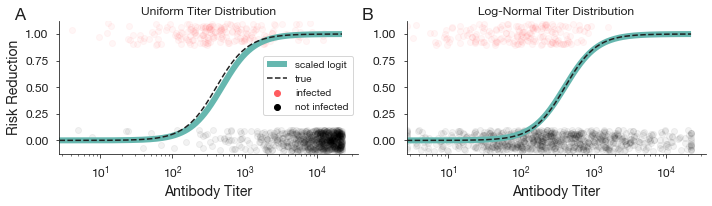

In [110]:
distributions = ["Uniform Titer Distribution","Log-Normal Titer Distribution"]
dist_names = [get_uniform_Ab_titers, get_lognormal_Ab_titers]
gen_func = "sigmoid"
param_dict = get_params_for_link_function(gen_func)

figure_mosaic = """
AB
"""
fig_labs = ["A","B"]

fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic,figsize=(10,3))

for ii,dist in enumerate(dist_names):
    # Showing how standard logistic regression estimates risk
    TND = generate_TND_data(N,gen_func,protection_params=param_dict,Ab_distribution=dist)
    Ab_logged = TND[0]; infected = TND[1]
    Ab_unlogged = np.exp(Ab_logged)
    Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
    infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

    # Use logistic regression to estimate risk 
    potential_Abs_logged = np.arange(min(Ab_logged),max(Ab_logged),0.01)
    potential_Abs_unlogged = np.exp(potential_Abs_logged)
    inf_probs = fit_logistic_regression(Ab_logged,infected,potential_Abs_logged)
    RR_estimate = one_minus_OR(inf_probs)

    # Fit scaled logistic
    fitted_params = fit_scaled_logistic(Ab_logged,infected)
    # Extract fitted parameters and plug in
    fitted_k, fitted_beta_0, fitted_beta_1 = fitted_params
    inf_probs_scaled = scaled_logistic(potential_Abs_logged, fitted_k, fitted_beta_0, fitted_beta_1)
    RR_estimate_scaled = one_minus_OR(inf_probs_scaled)

    # Calculate estimated and simulated VE
    exec(f"X = {gen_func}") 
    p1,p2 = list(param_dict.values())
    RR_simulated = [X(Ab,p1,p2) for Ab in potential_Abs_logged]

    # Plot a single simulation for each data generating function
    ax = axes[fig_labs[ii]]
    ax.scatter(Ab_unlogged_samples[infected_samples > 0.5], infected_samples[infected_samples > 0.5], c=inf_color, alpha=0.05,label="infected")
    ax.scatter(Ab_unlogged_samples[infected_samples < 0.5], infected_samples[infected_samples < 0.5], c="k" ,alpha=0.05,label="not infected")
    # estimate_standard = ax.plot(potential_Abs,inf_probs,c=logistic_color,label="logistic",linewidth=6)
    estimated = ax.plot(potential_Abs_unlogged,RR_estimate_scaled,c=scaled_logit_color,label="scaled logit",linewidth=6)
    simulated = ax.plot(potential_Abs_unlogged,RR_simulated,c=ALMOST_BLACK,linestyle="dashed",label="true")
    ax.set_title(distributions[ii])
    hide_right_top_axis(ax)
    ax.set_ylim([-0.125,1.125])

axes["A"].set_ylabel("Risk Reduction")   
axes["A"].set_xlabel("Antibody Titer")
axes["B"].set_xlabel("Antibody Titer")

leg = axes["A"].legend(bbox_to_anchor=(1,0.25),loc="lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

xpad = -0.15; ypad = 1.1
label_subplots(axes,[xpad,xpad,xpad,xpad], y_pad=ypad, labels=fig_labs)

ax_labs = ["A","B"]
for ax_lab in ax_labs:
    axes[ax_lab].set_xscale('log')
    axes[ax_lab].set_xlim([min(Ab_unlogged),None])
    finalize(axes[ax_lab])

# Show the plot
plt.grid(False)
plt.tight_layout()
plt.savefig("figs/Ab_dist.jpg",dpi=300,bbox_inches='tight')
plt.show()

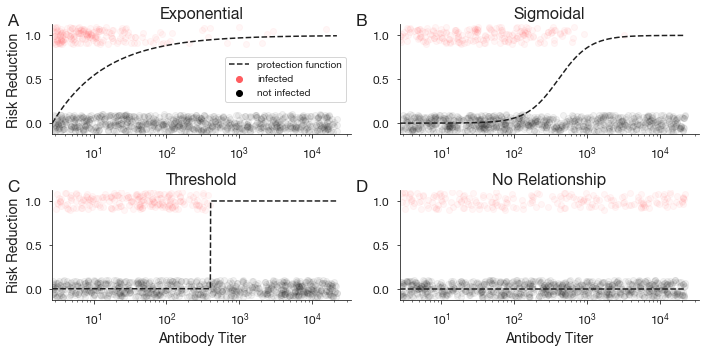

In [116]:
data_gen_functions = ["exponential","sigmoid","threshold","no_relationship"]
titles = ["Exponential","Sigmoidal","Threshold","No Relationship"]
function_error_dict = {}

figure_mosaic = """
AB
CD
"""
fig_labs = ["A","B","C","D"]

fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic,figsize=(10,5))

for ii,gen_func in enumerate(data_gen_functions):
    # Showing how standard logistic regression estimates risk
    param_dict = get_params_for_link_function(gen_func)
    TND = generate_TND_data(N,gen_func,protection_params=param_dict)
    Ab_logged = TND[0]; infected = TND[1]
    Ab_unlogged = np.exp(Ab_logged)
    Ab_unlogged_samples, infected_samples = generate_paired_random_sample(n_plot,Ab_unlogged,infected)
    infected_samples = jitter_vector(infected_samples,jitter_range=0.1)

    # Calculate estimated and simulated VE
    if gen_func != "no_relationship":
        exec(f"X = {gen_func}") 
        p1,p2 = list(param_dict.values())
        RR_simulated = X(potential_Abs_logged,p1,p2)
    else:
        RR_simulated = no_relationship(potential_Abs_logged)

    # Plot a single simulation for each data generating function
    ax = axes[fig_labs[ii]]
    ax.scatter(Ab_unlogged_samples[infected_samples > 0.5], infected_samples[infected_samples > 0.5], c=inf_color, alpha=0.05,label="infected")
    ax.scatter(Ab_unlogged_samples[infected_samples < 0.5], infected_samples[infected_samples < 0.5], c="k" ,alpha=0.05,label="not infected")

    simulated = ax.plot(potential_Abs_unlogged,RR_simulated,c=ALMOST_BLACK,linestyle="dashed",label="protection function")
    ax.set_title(titles[ii],size=16)
    hide_right_top_axis(ax)
    ax.set_ylim([-0.125,1.125])

axes["A"].set_ylabel("Risk Reduction")   
axes["C"].set_ylabel("Risk Reduction")   
axes["C"].set_xlabel("Antibody Titer")
axes["D"].set_xlabel("Antibody Titer")

leg = axes["A"].legend(bbox_to_anchor=(1,0.25),loc="lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

xpad = -0.15; ypad = 1.1
label_subplots(axes,[xpad,xpad,xpad,xpad], y_pad=ypad, labels=fig_labs)

ax_labs = ["A","B","C","D"]
for ax_lab in ax_labs:
    axes[ax_lab].set_xscale('log')
    axes[ax_lab].set_xlim([min(Ab_unlogged),None])
    finalize(axes[ax_lab])

# Show the plot
plt.grid(False)
plt.tight_layout()
plt.savefig("figs/ProtectionFunctions.jpg",dpi=300,bbox_inches='tight')
plt.show()